# Notebook to Explore Samples of NEON Hyperspectral Image Data

Written by Chris Stewart - 2021/02/10

The purpose of this notebook is to explore a subset of NEON hyperspectral imaging, perform some basic data loading/processing, exploratory data analysis, and some resampling and visualization

NEON Citation:
National Ecological Observatory Network. 2021. Data Product DP3.30006.001, Spectrometer orthorectified surface directional reflectance - mosaic. Provisional data downloaded from http://data.neonscience.org on February 11, 2021. Battelle, Boulder, CO, USA NEON. 2021.

## NB OVERVIEW & TO DO:

### 1. Data loading code:
- Code that takes in a filepath and walks the folders and files and returns filenames and paths of all h5 files - DONE
- Function that takes in the filename and path of a hdf5 (.h5) file and reads the hdf5 structure and available datasets, prints group names, dataset names and attributes - DONE
- Function that takes in a filename and path loads in the reflectance data and a dictionary of the metadata - DONE

### 2. EDA:

- check dimensions of arrays and size in memory - DONE
- min/maxes of values - DONE
- Check band centres and see if they are consistant (i.e. evenly distributed accross spectrum) - DONE
- Check FWHM distances and see if they are consistant - DONE
- plot spectral graph, for single and multiple spectra - DONE
- plot histograms of distributions of values for reflectance and wavelength

optional: tool that shows image and lets you click on pixel and shows you the spectral graph on that pixel or range of pixels

### Visualize the image:
need function/code that can translate between spectral and reflectance data and RGB or other values for easy plotting/visualization with PIL - DONE ish

### Spatial resampling:
write function that takes in array of data and downscales based on desired GSD scale parameter "Average method" - DONE (Bugs)




### NDVI:
function that calculates NDVI and translates that to RGB values for visualization
plot of NDVI 







In [169]:
# libraries

import warnings
warnings.filterwarnings('ignore')

# data
import pandas as pd
# import geopandas as geopd # for working with geolocation data
import numpy as np
import hyperspy.api as hs
import h5py
from PIL import Image

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import cartopy.crs as ccrs # for working with geolocation data
# import cartopy.feature as cfeature

# ml
import sklearn as skl
import skimage as skim

# utilites
import sys
import os 
from pathlib import Path
import datetime as dt
from tqdm.notebook import tqdm, trange # progress bars
tqdm.pandas()

# dataframe options
pd.set_option('display.max_columns', None)

%matplotlib inline

## 1. Data loading functions:

1. find_files - code that takes in a filepath and walks the folders and files and returns filenames and paths of all h5 files
2. hdf5 file dump - useful exploratory code to map the structure of NEON's hdf5 files and metadata
3. h5data2array - function that loads the given h5 file and returns the relevant datasets: refl_clean, wavelength_array, FWHM_array, metadata

### Data loading #1: find_files function

This will locate all hdf5 files within a given data directory and return a dictionary of filenames and paths.

In [2]:
def find_files(data_dir_path):
    """
    This function takes in a path to a data directory, walks the directory and 
    returns a dictionary of the filenames and paths of all the data files.
    """
    
    # get all the h5 data filenames and paths
    file_dict = {} # to store file:path pairs
    print('Finding data files...')
    for p, _, file in os.walk(data_dir_path): # get all the data files and their paths
        for f in file:
            if f.endswith(".h5"): # only .h5 files read in
                file_dict[f] = os.path.join(p, f) # if you want a string path
                #file_dict[f] = Path(os.path.join(p, f)) # if you want a Path object path

    return file_dict

### Test out the find_files function:

In [3]:
data_dir_path = Path(os.getcwd()).parents[0] / 'data' / 'NEON' # get path to data files

file_dict = find_files(data_dir_path)
file_dict

Finding data files...


{'NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5074000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\NEON\\

### Data loading #2: h5dump function

This will give us the structure of the NEON hdf5 file and its available datasets within.

In [4]:
# # my manual lame way
# with h5py.File("NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5",'r') as f:
#     groupNames_0 = [n for n in f.keys()]
#     print(groupNames_0)
#     groupNames_1 = [n for n in f['ABBY'].keys()]
#     print(groupNames_1)
#     groupNames_2 = [n for n in f['ABBY/Reflectance'].keys()]
#     print(groupNames_2)
#     #datasetNames = [n for n in groupNames_1.keys()]
#     #dset = groupNames_1['Reflectance']
#     #dset

In [5]:
# HDF5 file structure map from this SO answer: https://stackoverflow.com/a/53340677
# Much more better!
def descend_obj(obj,sep='\t'):
    """
    Iterate through groups in a HDF5 file and prints the groups and datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group,h5py._hl.files.File]:
        for key in obj.keys():
            print(sep,'-',key,':',obj[key])
            descend_obj(obj[key],sep=sep+'\t')
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print(sep+'\t','-',key,':',obj.attrs[key])

def h5dump(path,group='/'):
    """
    print HDF5 file metadata

    group: you can give a specific group, defaults to the root group
    """
    with h5py.File(path,'r') as f:
         descend_obj(f[group])

### Test out the h5dump function:

This will give us the structure of the NEON hdf5 file and its available datasets within - of particular interest to us here are three datasets:
- Wavelength
- Full Width Half Maximum (FWHM)
- Reflectance

In [6]:
h5dump("NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5")

	 - ABBY : <HDF5 group "/ABBY" (1 members)>
		 - Reflectance : <HDF5 group "/ABBY/Reflectance" (2 members)>
			 - Metadata : <HDF5 group "/ABBY/Reflectance/Metadata" (7 members)>
				 - Ancillary_Imagery : <HDF5 group "/ABBY/Reflectance/Metadata/Ancillary_Imagery" (14 members)>
					 - Aerosol_Optical_Depth : <HDF5 dataset "Aerosol_Optical_Depth": shape (1000, 1000), type "<i2">
							 - Band_Names : b'AOT (aerosol optical thickness at 550 nm)*1000'
							 - Data_Ignore_Value : -9999.0
							 - Description : b'Aerosol Optical Depth at 500 nm.'
							 - Scale_Factor : 1000.0
							 - Units : b'Aerosol Optical Depth at 500 nm.'
					 - Aspect : <HDF5 dataset "Aspect": shape (1000, 1000), type "<f4">
							 - Data_Ignore_Value : -9999.0
							 - Description : b'Aspect used as input to ATCOR'
							 - Dimension_Labels : b'-'
							 - Scale_Factor : 1.0
							 - Units : b'degrees'
					 - Cast_Shadow : <HDF5 dataset "Cast_Shadow": shape (1000, 1000), type "|u1">
							 - Data_Ign

### Data Loading: h5data2array function 

This loads the given h5 file and returns the relevant datasets:
- refl_clean: cleaned and scaled reflectance data
- wavelength_array: array of band wavelength centre
- FWHM_array: Full Width Half Maximum of bands
- metadata: includes some useful auxiliary information

Based on example code from NEON code examples:

https://www.neonscience.org/resources/learning-hub/tutorials/hdf5-intro-python

https://www.neonscience.org/resources/learning-hub/tutorials/calc-ndvi-tiles-py

In [7]:
def h5data2array(data_file_path):
    """
    h5dataset2array reads in a hdf5 file and extracts and returns:  
        1. reflectance array (with the no data value and reflectance scale factor applied)
        2. dictionary of metadata including spatial information, and wavelengths of the bands
    --------
    Parameters
        data_file_path -- full or relative path and name of reflectance hdf5 file
    --------
    Returns
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'nm' (string)
    --------
    Example Execution:
    --------
    refl_clean, wavelength_array, FWHM_array, metadata = h5data2array("NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5")
    
    """
    
    hdf5_file = h5py.File(data_file_path,'r') # open file
    #Get the site name
    file_attrs_str = str(list(hdf5_file.items())).split("'")
    sitename = file_attrs_str[1]

    # Extract the reflectance & wavelength datasets
    refl_obj = hdf5_file[sitename]['Reflectance']
    refl_data = refl_obj['Reflectance_Data'] # reflectance dataset

    # Create dictionary containing relevant metadata information
    metadata_dict = {}
    metadata_dict['map info'] = refl_obj['Metadata']['Coordinate_System']['Map_Info']
    metadata_dict['wavelength'] = refl_obj['Metadata']['Spectral_Data']['Wavelength']

    # Extract no data value & scale factor
    metadata_dict['data ignore value'] = float(refl_data.attrs['Data_Ignore_Value'])
    metadata_dict['reflectance scale factor'] = float(refl_data.attrs['Scale_Factor'])

    # Apply no data value
    refl_array = np.array(refl_data)
    arr_size = refl_data.shape
    if np.isin(refl_array, metadata_dict['data ignore value']).any():
        print('% No Data: ',np.round(np.count_nonzero(refl_array == metadata_dict['data ignore value'])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1)) # calculates % of missing data values
        refl_array[np.where(refl_array == metadata_dict['data ignore value'])] = np.nan # replace no data values with NaNs

    # Apply scale factor
    refl_clean = refl_array/metadata_dict['reflectance scale factor']

    
    # metadata
    # extract wavelength bands and FWHMs
    wavelength_array = refl_obj['Metadata']['Spectral_Data']['Wavelength'][...] # wavelength dataset
    FWHM_array = refl_obj['Metadata']['Spectral_Data']['FWHM'][...] # FWHM dataset
    
    # Extract spatial extent from attributes
    metadata_dict['spatial extent'] = refl_data.attrs['Spatial_Extent_meters']

    # Extract projection information
    metadata_dict['projection'] = refl_obj['Metadata']['Coordinate_System']['Proj4'][...]
    metadata_dict['epsg'] = int(refl_obj['Metadata']['Coordinate_System']['EPSG Code'][...])

    # Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl_obj['Metadata']['Coordinate_System']['Map_Info'][...]

    hdf5_file.close # close file

    return refl_clean, wavelength_array, FWHM_array, metadata_dict

### Test out the h5data2array function:

This will load in the three key datasets:
- Wavelength
- Full Width Half Maximum (FWHM)
- Reflectance

In [8]:
# test the h5data2array
data_file_path = file_dict['NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5']
refl_clean, wavelength_array, FWHM_array, metadata_dict = h5data2array(data_file_path)
refl_clean

array([[[0.0092, 0.0187, 0.0168, ..., 0.0184, 0.025 , 0.0483],
        [0.0108, 0.0179, 0.0136, ..., 0.0089, 0.0307, 0.0218],
        [0.0103, 0.0161, 0.016 , ..., 0.0216, 0.0352, 0.048 ],
        ...,
        [0.0115, 0.0211, 0.0224, ..., 0.0071, 0.0316, 0.088 ],
        [0.012 , 0.0229, 0.0215, ..., 0.0089, 0.0312, 0.0905],
        [0.0102, 0.0239, 0.0195, ..., 0.0425, 0.0499, 0.1174]],

       [[0.0126, 0.0198, 0.0178, ..., 0.0121, 0.0189, 0.0293],
        [0.0129, 0.0224, 0.0209, ..., 0.0333, 0.0183, 0.0628],
        [0.0141, 0.0176, 0.0191, ..., 0.0164, 0.0042, 0.0336],
        ...,
        [0.0158, 0.0272, 0.0239, ..., 0.0175, 0.0738, 0.0626],
        [0.0114, 0.0248, 0.0231, ..., 0.0324, 0.0851, 0.1389],
        [0.0132, 0.018 , 0.014 , ..., 0.0076, 0.0806, 0.093 ]],

       [[0.0122, 0.0209, 0.0247, ..., 0.0182, 0.0415, 0.0608],
        [0.0178, 0.0227, 0.0226, ..., 0.0253, 0.0282, 0.0371],
        [0.0125, 0.0175, 0.0242, ..., 0.0123, 0.0478, 0.0484],
        ...,
        [0.0

## 2. Exploratory Data Analysis:

After loading data let's perform some sanity checks and dig into values to better understand hyperspectral data.
- First let's check the dimensions of our data arrays and size in memory:

In [14]:
print("Reflectance dataset info:")
print("dtype: " + str(refl_clean.dtype))
print("Array Shape: " + str(refl_clean.shape))
print("Size in memory (Mbytes): " + str(refl_clean.nbytes/1000000)) # size of array in memory
print("-"*35)

print("Wavelength dataset info:")
print("dtype: " + str(wavelength_array.dtype))
print("Array Shape: " + str(wavelength_array.shape))
print("Size in memory (Kbytes): " + str(wavelength_array.nbytes/1000)) # size of array in memory
print("-"*35)

print("FWHM dataset info:")
print("dtype: " + str(FWHM_array.dtype))
print("Array Shape: " + str(FWHM_array.shape))
print("Size in memory (Kbytes): " + str(FWHM_array.nbytes/1000)) # size of array in memory
print("-"*35)

Reflectance dataset info:
dtype: float64
Array Shape: (1000, 1000, 426)
Size in memory (Mbytes): 3408.0
-----------------------------------
Wavelength dataset info:
dtype: float32
Array Shape: (426,)
Size in memory (Kbytes): 1.704
-----------------------------------
FWHM dataset info:
dtype: float32
Array Shape: (426,)
Size in memory (Kbytes): 1.704
-----------------------------------


- Check some overview stats and min/maxes of values:

In [77]:
print("Mean reflectance: "'{number:.{digits}f}'.format(number=refl_clean[:,:,:].mean(), digits=3))
print("Std Dev.: "'{number:.{digits}f}'.format(number=refl_clean[:,:,:].std(), digits=3))
print("Min reflectance: "'{number:.{digits}f}'.format(number=refl_clean[:,:,:].min(), digits=3))
print("Max reflectance: "'{number:.{digits}f}'.format(number=refl_clean[:,:,:].max(), digits=3))
print("-"*35)
print("Mean wavelength: "'{number:.{digits}f}'.format(number=wavelength_array.mean(), digits=3))
print("Std Dev.: "'{number:.{digits}f}'.format(number=wavelength_array.std(), digits=3))
print("Min wavelength: "'{number:.{digits}f}'.format(number=wavelength_array.min(), digits=3))
print("Max wavelength: "'{number:.{digits}f}'.format(number=wavelength_array.max(), digits=3))
print("-"*35)
print("Mean FWHM: "'{number:.{digits}f}'.format(number=FWHM_array.mean(), digits=3))
print("Std Dev.: "'{number:.{digits}f}'.format(number=FWHM_array.std(), digits=3))
print("Min FWHM: "'{number:.{digits}f}'.format(number=FWHM_array.min(), digits=3))
print("Max FWHM: "'{number:.{digits}f}'.format(number=FWHM_array.max(), digits=3))
print("-"*35)

Mean reflectance: 0.125
Std Dev.: 0.183
Min reflectance: 0.000
Max reflectance: 1.565
-----------------------------------
Mean wavelength: 1446.173
Std Dev.: 616.077
Min wavelength: 381.598
Max wavelength: 2510.749
-----------------------------------
Mean FWHM: 5.748
Std Dev.: 0.236
Min FWHM: 5.536
Max FWHM: 6.346
-----------------------------------


Interestingly we can see that even after scaling we get a maximum reflectance value of 1.565 -> is this an outlier/artifact or maybe due to object radiating its own EM emissions?

- Lets visualize what some reflectance signals looks like with some spectral graphs for multiple image pixels

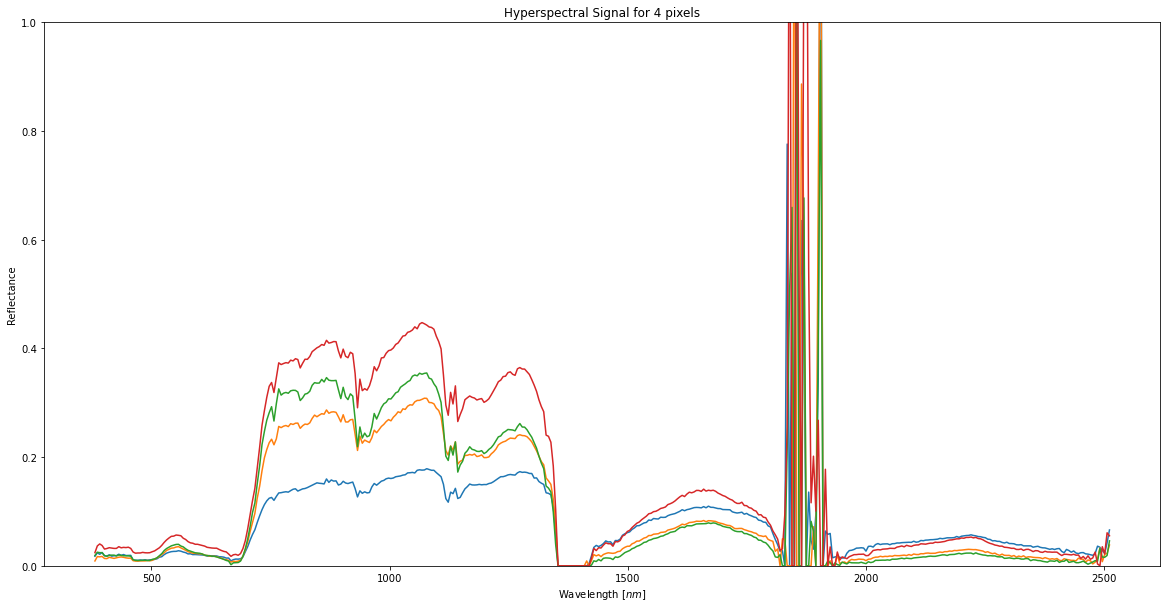

In [61]:
i, j = 0, 0
#fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(wavelength_array, refl_clean[i+50,j,:])
ax.plot(wavelength_array, refl_clean[i,j+50,:])
ax.plot(wavelength_array, refl_clean[i+800,j+800,:])
ax.plot(wavelength_array, refl_clean[i+900,j+900,:])
#ax.set_xticks(range(0, 250, 3000))
plt.title("Hyperspectral Signal for 4 pixels") # ["+str(i)+","+str(j)+"]")
plt.ylabel('Reflectance')
plt.ylim((0,1))
plt.xlabel('Wavelength [$nm$]')
plt.show()

We should also check the hyperspectral wavelength and FWHM metadata

- Check band centres and see if they are consistant (i.e. evenly distributed accross spectrum)
- Check FWHM distances and see if they are consistant

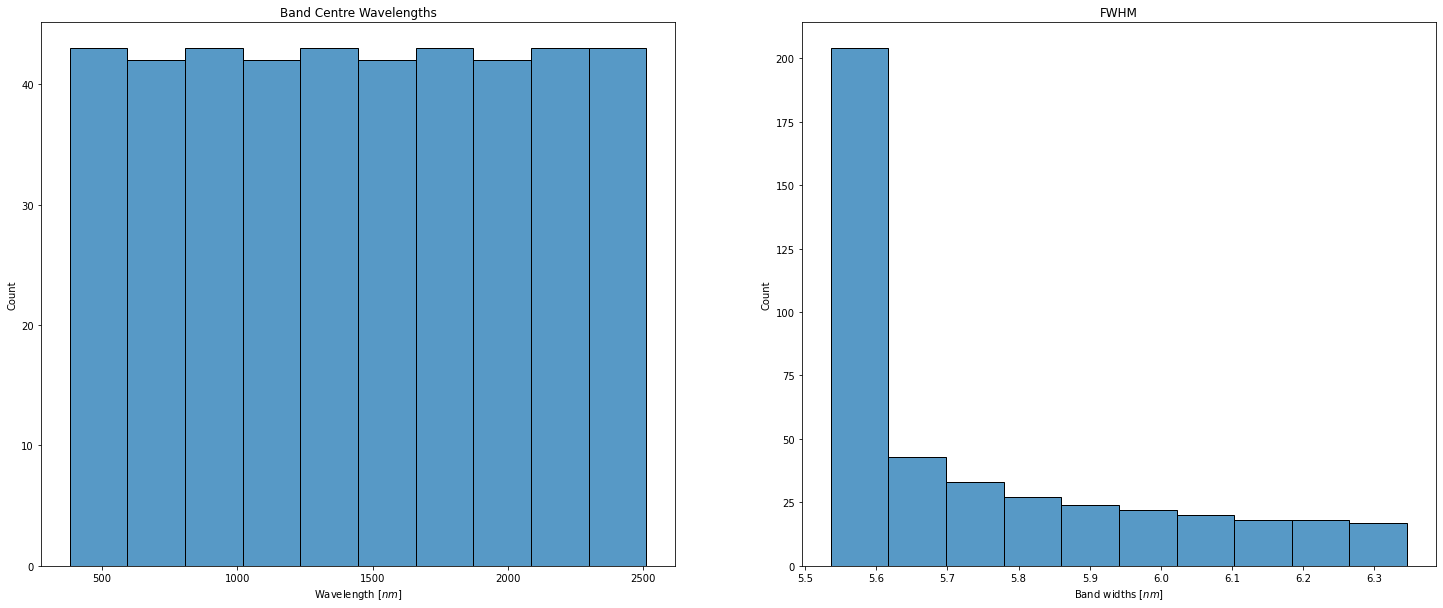

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
sns.histplot(data=wavelength_array, ax=ax[0])
sns.histplot(data=FWHM_array, ax=ax[1])

ax[0].set_xlabel("Wavelength [$nm$]")
ax[0].set_title("Band Centre Wavelengths")
ax[1].set_xlabel("Band widths [$nm$]")
ax[1].set_title("FWHM")


plt.show()

We can see the wavelengths are pretty evenly distributed and the FWHM are primarily < 5.6 nm with some slightly wider bands as well

Lets plot some lines to visualize the band centres:

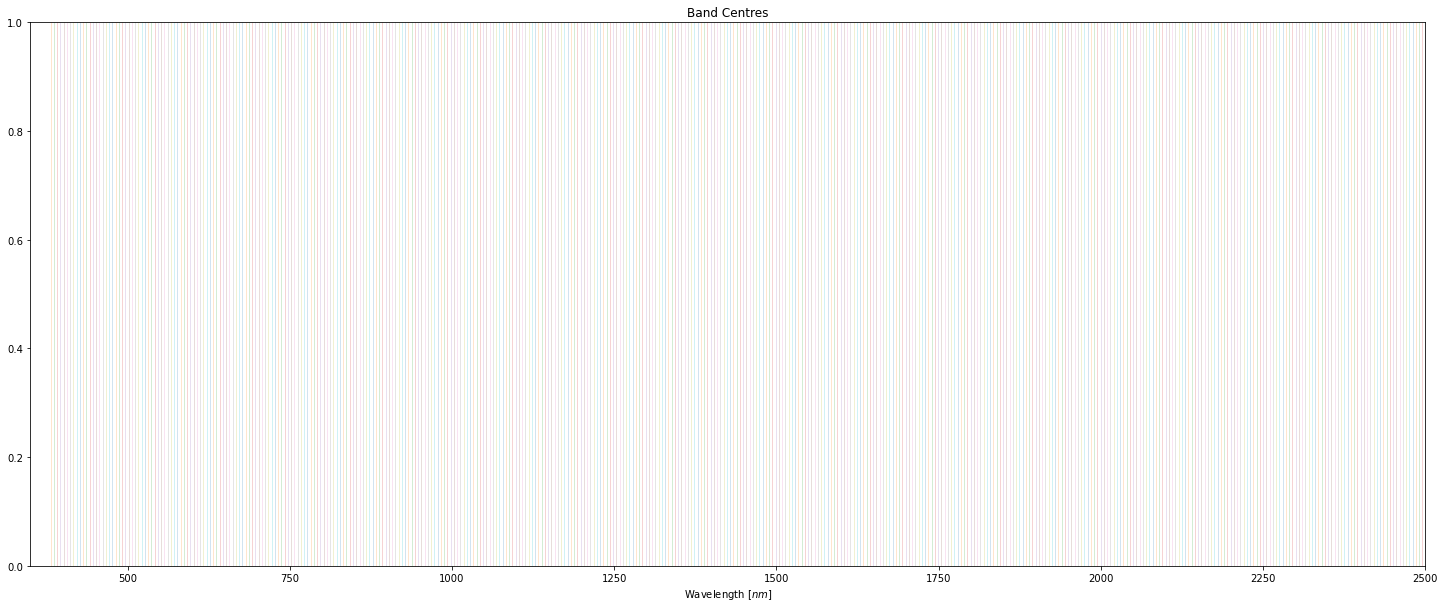

In [96]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.lineplot(data=wavelength_array, ax=ax)
#sns.histplot(data=FWHM_array, ax=ax[1])

ax.set_xlabel("Wavelength [$nm$]")
ax.set_title("Band Centre Wavelengths")

plt.title("Band Centres")
#plt.ylabel('Reflectance')
plt.ylim((0,1))
plt.xlim((350,2500))
plt.xlabel('Wavelength [$nm$]')

for w in wavelength_array:
    sns.lineplot(x=[w,w], y=[0,1], ax=ax)

plt.show()

## 3. Visualize Image

Quick function to pull out a few of the visible light bands and visualize the image

In [182]:
def toRGB(refl_clean, filename_output):
    """
    This is a rough way to convert visualize parts of a hyperspectrum and show them in RGB colour images
    This tool was helpful: https://academo.org/demos/wavelength-to-colour-relationship/
    and this resource: https://towardsdatascience.com/image-processing-with-python-5b35320a4f3c
    -----------------------------------------------------------------------------------------------------
    red ~= 625–740 nm -> pick 700 nm -> rgb(255,0,0) : wavelength_array[64] = 702.223
    green ~= 495–570 nm -> pick 510 nm -> rgb(0,255,0) : wavelength_array[26] = 511.8519
    blue ~= 450-495 nm -> pick 440 nm - > rgb(0,0,255) : wavelength_array[12] = 441.7151
    
    """
    
    red = refl_clean[:,:,64] + refl_clean[:,:,64-1] + refl_clean[:,:,64+1]
    green = refl_clean[:,:,26] + refl_clean[:,:,26-1] + refl_clean[:,:,26+1]
    blue = refl_clean[:,:,12] + refl_clean[:,:,12-1] + refl_clean[:,:,12+1]
    
    # clamping function for values outside the acceptable range
    def clamp(array, low, high):
        array[array < low] = low
        array[array > high] = high
        return array
    
    red_clampd = clamp(red, 0.0, 1.0)
    green_clampd = clamp(green, 0.0, 1.0)
    blue_clampd = clamp(blue, 0.0, 1.0)

    colour_array = np.stack((red_clampd, green_clampd, blue_clampd), axis=-1)
     
    im = Image.fromarray(np.uint8(colour_array*255))

    plt.imshow(np.asarray(im))
    plt.show()

    im.save(filename_output) # save file to .png
    #im.show()

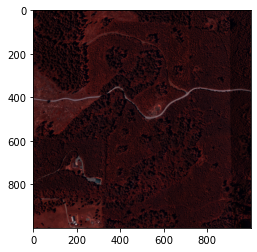

In [183]:
toRGB(refl_clean, 'test_img.png')

## 3. Spatial Resampling
A function that takes in array of data and downscales based on desired GSD scale parameter
"Average method"

In [185]:
def downSample_array(img_array, GSD_input, GSD_output):
    """
    Takes in a img array, input GSD and desired output GSD and downsamples the array by
    a calculated downsampling factor (the ratio between the )
    
    """
    downsample_factor = max(int(round(GSD_output/GSD_input)),1) # calculate the downsampling factor - only integers!
    img_array_ds = skim.measure.block_reduce(img_array[:, :, :], block_size=(downsample_factor, downsample_factor, 1), func=np.mean)
    
    return img_array_ds

Lets test this in action

In [173]:
refl_clampd = clamp(refl_clean, 0, 1) # first clamp to [0,1] range


ds_img_array_20m = downSample_array(refl_clampd, 1, 20) # try a 20 m GSD


Now lets try to generate the images

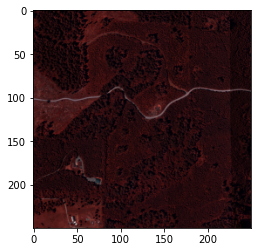

In [186]:
# 4 m GSD
refl_clampd = clamp(refl_clean, 0, 1) # first clamp to [0,1] range
# downsample to a 4 m GSD
ds_img_array_4m = downSample_array(refl_clampd, 1, 4) # try a 4 m GSD
# output the 4 m GSD one
toRGB(ds_img_array_4m, 'ds_img_4m.png')

In [190]:
print("Original Image Size:")
print(refl_clampd.shape)
print("Downsampled Image Size:")
print(ds_img_array_4m.shape)

Original Image Size:
(1000, 1000, 426)
Downsampled Image Size:
(250, 250, 426)


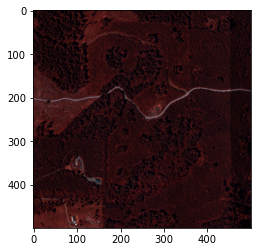

In [191]:
# 2 m GSD
refl_clampd = clamp(refl_clean, 0, 1) # first clamp to [0,1] range
# downsample to a 2 m GSD
ds_img_array_2m = downSample_array(refl_clampd, 1, 2) # try a 2 m GSD
# output the 2 m GSD one
toRGB(ds_img_array_2m, 'ds_img_2m.png')

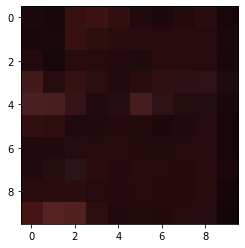

In [192]:
# 100 m GSD
refl_clampd = clamp(refl_clean, 0, 1) # first clamp to [0,1] range
# downsample to a 100 m GSD
ds_img_array_100m = downSample_array(refl_clampd, 1, 100) # try a 100 m GSD
# output the 100 m GSD one
toRGB(ds_img_array_100m, 'ds_img_100m.png')

## WIP CODE BELOW CLEAN/DELETE LATER -----------------------------------

In [ ]:
# - plot histograms of distributions of values for reflectance


In [71]:

# fig, ax = plt.subplots(figsize=(20,10))
# #fig, ax = plt.subplots(nrows=7, ncols=3, figsize=(20, 38))

# # array dimension lengths
# x_len = refl_clean[0:5].shape[0]
# y_len = refl_clean[0:5].shape[1]
# z_len = refl_clean.shape[2]

# cmap = sns.color_palette("Spectral", as_cmap=True)

# for x in range(x_len):
#     for y in range(y_len):
#             sns.lineplot(x=wavelength_array, y=refl_clean[x,y,:], ax=ax)

# plt.show()

In [80]:
# # try and load image into HyperSpy
# img = hs.load('NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5', reader="h5")      #file_dict[file_names_ls[0]])
# img        

In [ ]:
# Example of writing data to an h5 file

# # Write a new HDF file containing this spectrum
#         f = h5.File("VegetationSpectra.h5", "w")
#         rdata = f.create_dataset("VegetationSpectra", data=reflectanceData)
#         attrs = rdata.attrs
#         attrs.create("Wavelengths", data=wavelengthData)
#         f.close()

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, -z, zdir='z', c= 'red')
# plt.savefig("demo.png")

In [164]:
# #import matplotlib.pyplot as plt
# #import numpy as np
# #import h5py, os, copy

# def aop_h5refl2array(refl_filename):
#     """aop_h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
#            1. reflectance array (with the no data value and reflectance scale factor applied)
#            2. dictionary of metadata including spatial information, and wavelengths of the bands
#     --------
#     Parameters
#         refl_filename -- full or relative path and name of reflectance hdf5 file
#     --------
#     Returns 
#     --------
#     reflArray:
#         array of reflectance values
#     metadata:
#         dictionary containing the following metadata:
#             bad_band_window1 (tuple)
#             bad_band_window2 (tuple)
#             bands: # of bands (float)
#             data ignore value: value corresponding to no data (float)
#             epsg: coordinate system code (float)
#             map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
#             reflectance scale factor: factor by which reflectance is scaled (float)
#             wavelength: wavelength values (float)
#             wavelength unit: 'm' (string)
#     --------
#     NOTE: This function applies to the NEON hdf5 format implemented in 2016, and should be used for
#     data acquired 2016 and after. Data in earlier NEON hdf5 format (collected prior to 2016) is 
#     expected to be re-processed after the 2018 flight season. 
#     --------
#     Example Execution:
#     --------
#     sercRefl, sercRefl_metadata = h5refl2array('NEON_D02_SERC_DP3_368000_4306000_reflectance.h5') """

    

#     #Read in reflectance hdf5 file 
#     hdf5_file = h5py.File(refl_filename,'r')

#     #Get the site name
#     file_attrs_string = str(list(hdf5_file.items()))
#     file_attrs_string_split = file_attrs_string.split("'")
#     sitename = file_attrs_string_split[1]

#     #Extract the reflectance & wavelength datasets
#     refl = hdf5_file[sitename]['Reflectance']
#     reflData = refl['Reflectance_Data']
#     reflRaw = refl['Reflectance_Data'].value

#     #Create dictionary containing relevant metadata information
#     metadata = {}
#     metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
#     metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

#     #Extract no data value & scale factor
#     metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
#     metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
#     #metadata['interleave'] = reflData.attrs['Interleave']

#     #Apply no data value
#     reflClean = reflRaw.astype(float)
#     arr_size = reflClean.shape
#     if metadata['data ignore value'] in reflRaw:
#         print('% No Data: ',np.round(np.count_nonzero(reflClean==metadata['data ignore value'])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1))
#         nodata_ind = np.where(reflClean==metadata['data ignore value'])
#         reflClean[nodata_ind]=np.nan 

#     #Apply scale factor
#     reflArray = reflClean/metadata['reflectance scale factor']

#     #Extract spatial extent from attributes
#     metadata['spatial extent'] = reflData.attrs['Spatial_Extent_meters']

#     #Extract bad band windows
#     metadata['bad band window1'] = (refl.attrs['Band_Window_1_Nanometers'])
#     metadata['bad band window2'] = (refl.attrs['Band_Window_2_Nanometers'])

#     #Extract projection information
#     #metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
#     metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)

#     #Extract map information: spatial extent & resolution (pixel size)
#     mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value

#     hdf5_file.close        

#     return reflArray, metadata

# def plot_aop_refl(band_array,refl_extent,colorlimit=(0,1),ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='Greys'):

#     '''plot_refl_data reads in and plots a single band or 3 stacked bands of a reflectance array
#     --------
#     Parameters
#     --------
#         band_array: array of reflectance values, created from aop_h5refl2array
#         refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) 
#                      use metadata['spatial extent'] from aop_h5refl2array function
#         colorlimit: optional, range of values to plot (min,max). 
#                     - helpful to look at the histogram of reflectance values before plotting to determine colorlimit.
#         ax: optional, default = current axis
#         title: optional; plot title (string)
#         cmap_title: optional; colorbar title 
#         colormap: optional (string, see https://matplotlib.org/examples/color/colormaps_reference.html) for list of colormaps
#     --------
#     Returns 
#     --------
#         plots flightline array of single band of reflectance data
#     --------

#     Examples:
#     --------
#     plot_aop_refl(sercb56,
#               sercMetadata['spatial extent'],
#               colorlimit=(0,0.3),
#               title='SERC Band 56 Reflectance',
#               cmap_title='Reflectance',
#               colormap='Greys_r') '''

#     import matplotlib.pyplot as plt

#     plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
#     if cbar == 'on':
#         cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
#         cbar.set_label(cmap_title,rotation=90,labelpad=20)
#     plt.title(title); ax = plt.gca(); 
#     ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation for ticklabels
#     rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

# def stack_rgb(reflArray,bands):

#     red = reflArray[:,:,bands[0]-1]
#     green = reflArray[:,:,bands[1]-1]
#     blue = reflArray[:,:,bands[2]-1]

#     stackedRGB = np.stack((red,green,blue),axis=2)

#     return stackedRGB

# def plot_aop_rgb(rgbArray,ext,ls_pct=5,plot_title=''):

#     from skimage import exposure

#     pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (ls_pct,100-ls_pct))
#     img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
#     plt.imshow(img_rescale,extent=ext)
#     plt.title(plot_title + '\n Linear ' + str(ls_pct) + '% Contrast Stretch'); 
#     ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
#     rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree